In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import time

In [2]:
adata = sc.datasets.paul15()

C:\Anaconda3\lib\site-packages\scanpy\datasets\_datasets.py:200: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['iroot'] = 840


In [3]:
# Select top 1000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,flavor='cell_ranger',n_top_genes=1000,log=False)
# Subset the genes
adata = adata[:, filter_result.gene_subset]
# Log transformation and scaling
sc.pp.log1p(adata)

C:\Anaconda3\lib\site-packages\scanpy\preprocessing\_deprecated\highly_variable_genes.py:183: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersion']
C:\Anaconda3\lib\site-packages\scanpy\preprocessing\_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.


C:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
C:\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


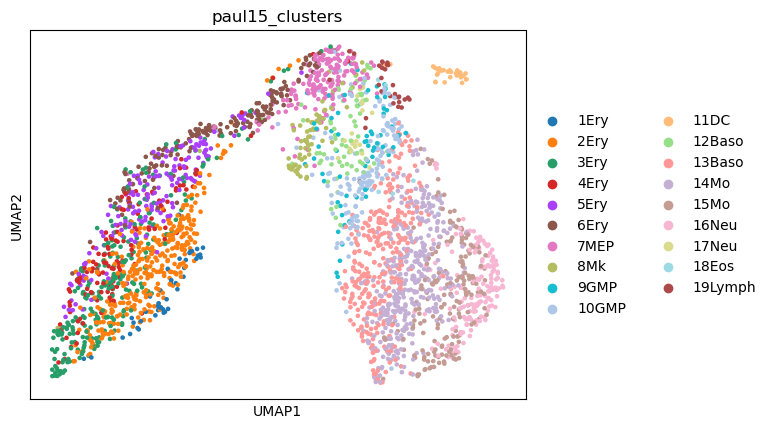

In [4]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['paul15_clusters'])

In [5]:
X = adata.X
data_clusters = adata.obs['paul15_clusters']
zip_types = dict(zip(data_clusters.cat.categories,adata.uns['paul15_clusters_colors']))
cell_clusters  =  [zip_types[i] for i in data_clusters.values]

In [6]:
var_names = adata.var_names
obs_names = adata.obs_names

In [7]:
%load_ext rpy2.ipython

C:\Anaconda3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


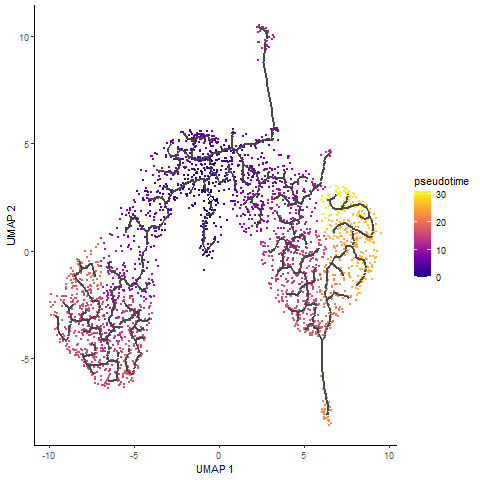

In [20]:
%%R -i X,obs_names,var_names -o pseudotime

suppressMessages(library(monocle3, quietly=TRUE))
suppressMessages(library(ggplot2))

pd = data.frame(rownames = obs_names)
rownames(pd) = obs_names

fd = data.frame(gene_short_name = var_names)
rownames(fd) = var_names

cds <- new_cell_data_set(t(as.matrix(X)),
                         cell_metadata = pd,
                         gene_metadata = fd)

cds <- preprocess_cds(cds, method = 'PCA',num_dim = 50,norm_method='none')
cds <- reduce_dimension(cds,reduction_method = 'UMAP', umap.min_dist = 0.5, umap.n_neighbors = 10,preprocess_method ='PCA')
cds <- cluster_cells(cds,cluster_method = 'leiden',resolution=1)
cds <- learn_graph(cds,use_partition =FALSE)
cds <- order_cells(cds,root_cells=rownames(pd)[841])
pseudotime <- pseudotime(cds)/max(pseudotime(cds))

plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

In [22]:
pd.DataFrame(pseudotime).to_csv('paul.monocle_pseudotime.csv')